# Density Functional Theory calculation of the benzene molecule

In this notebook cell, we perform a single-point Density Functional Theory (DFT) calculation on a BH3 molecule.

## Showing atomic fuzzy cells

Cannot find module tqdm


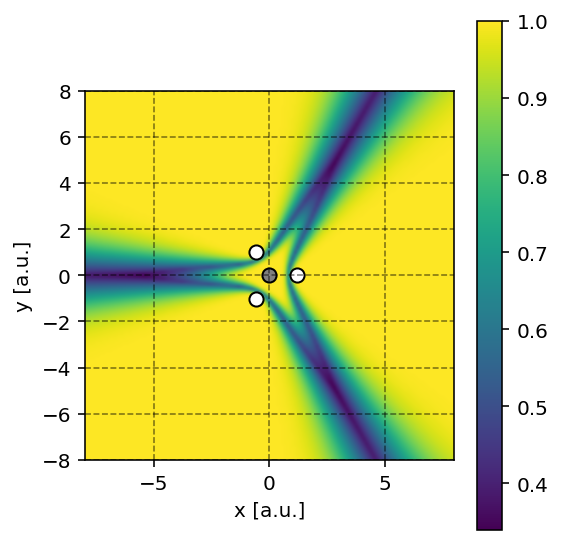

In [1]:
from pydft import MolecularGrid
from pyqint import Molecule
import numpy as np
import matplotlib.pyplot as plt

# construct molecule
mol = Molecule()
mol.add_atom("B",  0.000,  0.000,  0.000)
mol.add_atom("H",  1.190,  0.000,  0.000)
mol.add_atom("H", -0.595,  1.031,  0.000)
mol.add_atom("H", -0.595, -1.031,  0.000)
cgfs, atoms = mol.build_basis('sto3g')

# construct molecular grid
molgrid = MolecularGrid(atoms, cgfs)

# produce grid of sampling points to calculate the atomic
# weight coefficients for
N = 150
sz = 8
x = np.linspace(-sz,sz,N)
xv,yv = np.meshgrid(x,x)
points = np.array([[x,y,0] for x,y in zip(xv.flatten(),yv.flatten())])

# calculate the atomic weights
mweights = molgrid.calculate_weights_at_points(points, k=3)

# plot the atomic weights
plt.figure(dpi=144, figsize=(4,4))
plt.imshow(np.max(mweights,axis=0).reshape((N,N)),
           extent=(-sz,sz,-sz,sz), interpolation='bicubic')
plt.xlabel('x [a.u.]')
plt.ylabel('y [a.u.]')
plt.colorbar()
plt.grid(linestyle='--', color='black', alpha=0.5)

# add the atoms to the plot
r = np.zeros((len(atoms), 3))
for i,at in enumerate(atoms):
    r[i] = at[0]
plt.scatter(r[0:1,0], r[0:1,1], s=50.0, color='grey', edgecolor='black')
plt.scatter(r[1:4,0], r[1:4,1], s=50.0, color='white', edgecolor='black')

plt.tight_layout()
plt.show()

## Showing self-consistent field matrices

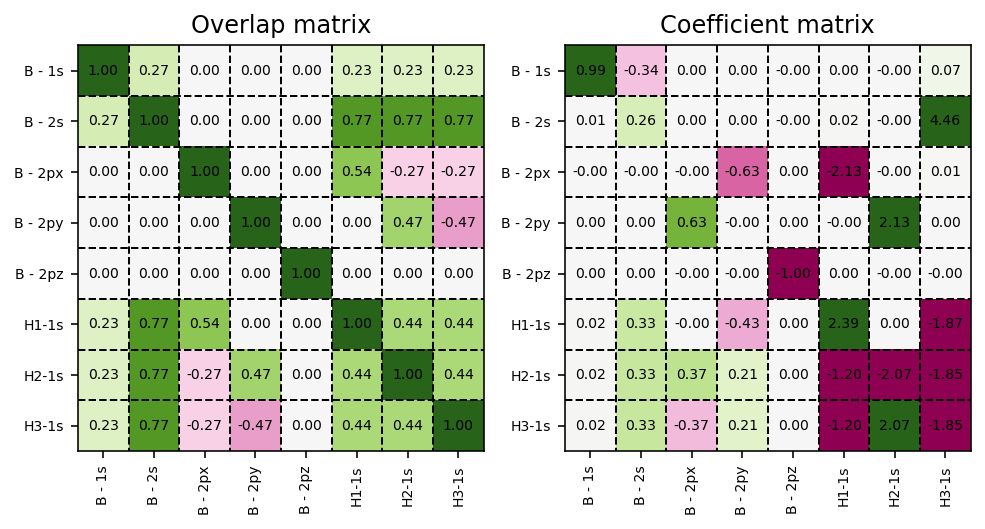

In [7]:
from pydft import DFT
import matplotlib.pyplot as plt

def plot_matrix(ax, mat, xlabels=None, ylabels=None, title = None, xlabelrot=90):
    """
    Produce plot of matrix
    """
    ax.imshow(mat, vmin=-1, vmax=1, cmap='PiYG')
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            ax.text(i, j, '%.2f' % mat[j,i], ha='center', va='center',
                    fontsize=7)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.hlines(np.arange(1, mat.shape[0])-0.5, -0.5, mat.shape[0] - 0.5,
              color='black', linestyle='--', linewidth=1)
    ax.vlines(np.arange(1, mat.shape[0])-0.5, -0.5, mat.shape[0] - 0.5,
              color='black', linestyle='--', linewidth=1)
    
    ax.set_xticks(np.arange(0, mat.shape[0]))
    if xlabels is not None:
        ax.set_xticklabels(xlabels, rotation=xlabelrot)
    ax.set_yticks(np.arange(0, mat.shape[0]))
    
    if ylabels is not None:
        ax.set_yticklabels(ylabels, rotation=0)
    ax.tick_params(axis='both', which='major', labelsize=7)
    
    if title is not None:
        ax.set_title(title)

# perform DFT calculation on the BH3 molecule
# (note: if you want to improve the accuracy of the calculation, increase nshells, nangpts, lmax)
# (e.g.: dft = DFT(mol, basis='sto3g', nshells=64, nangpts=590, lmax=8)
dft = DFT(mol, basis='sto3g')
en = dft.scf(1e-6)

# build list of basis functions
labels = []
for o in ['1s', '2s', '2px', '2py', '2pz']:
    labels.append('B - %s' % o)
for i in range(3):
    labels.append('H%i-1s' % (i+1))

fig, ax = plt.subplots(1, 2, dpi=144, figsize=(8,4))
plot_matrix(ax[0], dft.get_data()['S'], xlabels=labels, ylabels=labels, title='Overlap matrix')
plot_matrix(ax[1], dft.get_data()['C'], xlabels=labels, ylabels=labels, title='Coefficient matrix')

## Plot molecular orbitals

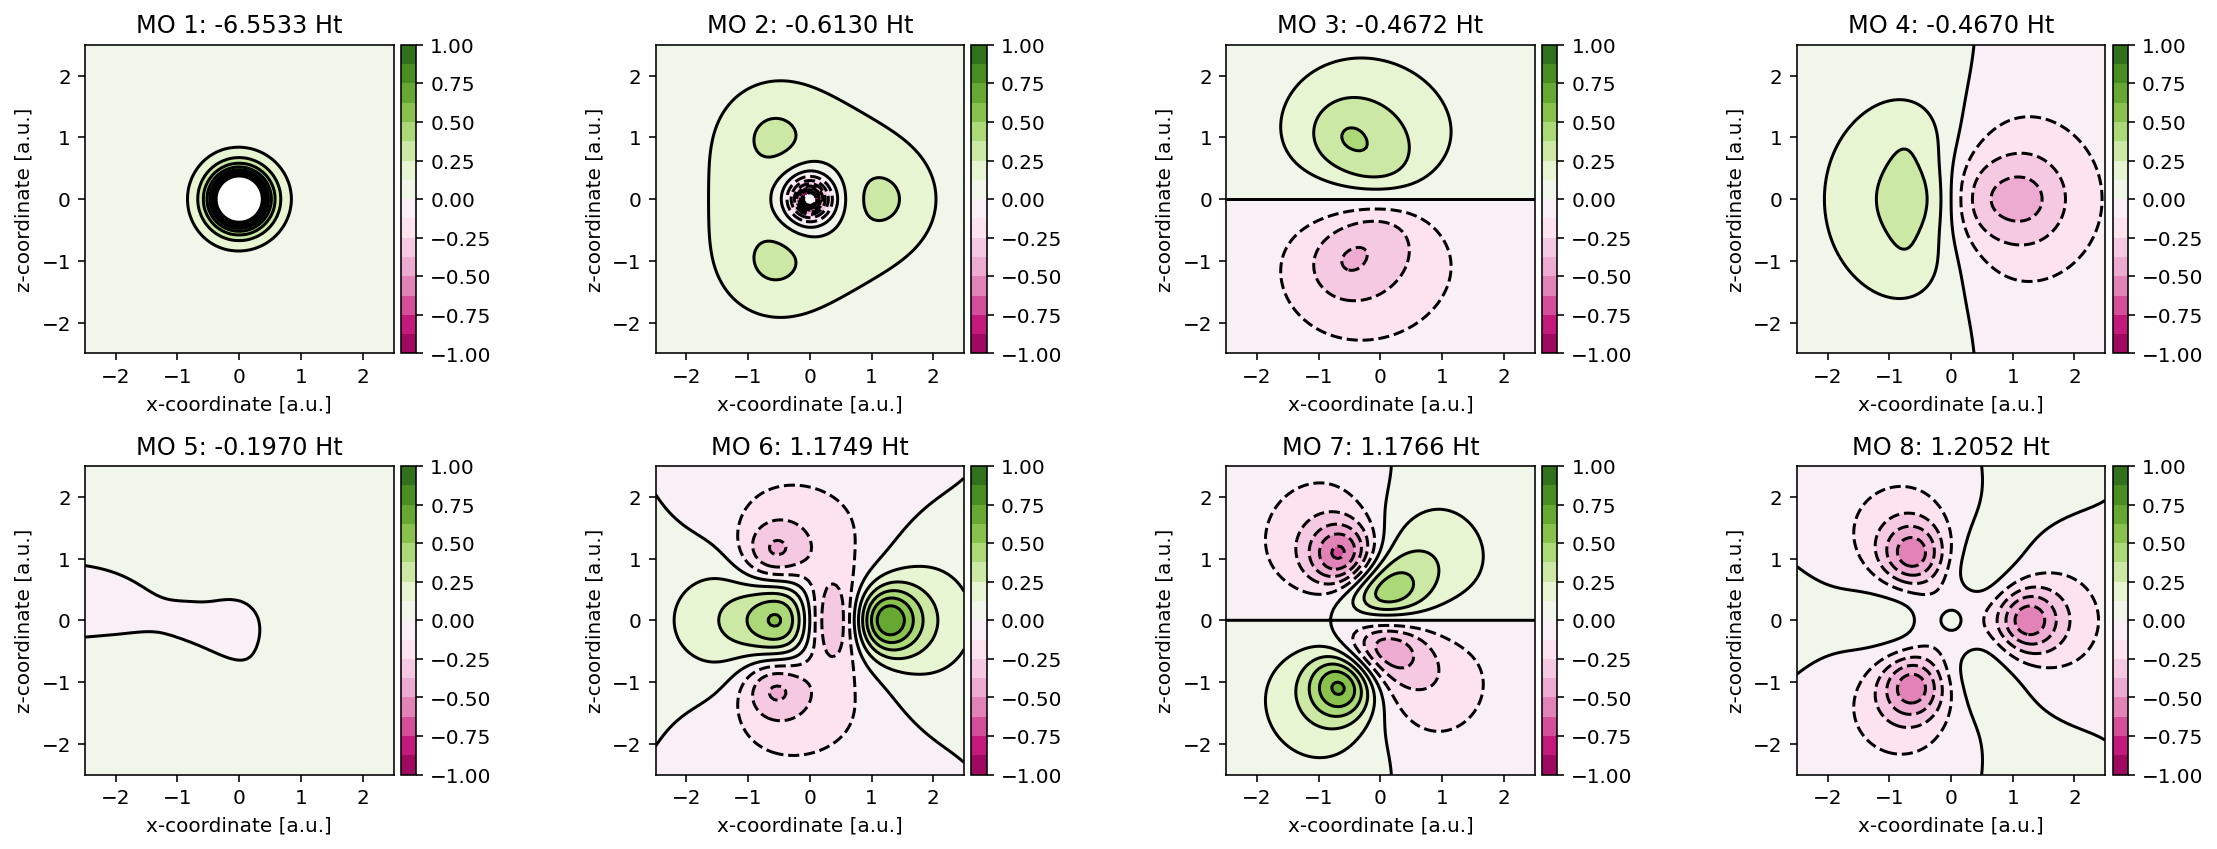

In [4]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# grab molecular orbital energies and coefficients
orbc = dft.get_data()['C']
orbe = dft.get_data()['orbe']  

# generate grid of points and calculate the electron density for these points
sz = 5      # size of the domain
npts = 100  # number of sampling points per cartesian direction

# produce meshgrid for the xy-plane
x = np.linspace(-sz/2,sz/2,npts)
yy, xx = np.meshgrid(x, x, indexing='ij')
gridpoints = np.zeros((yy.shape[0], xx.shape[1], 3))
gridpoints[:,:,0] = xx
gridpoints[:,:,1] = yy
gridpoints[:,:,2] = np.zeros_like(xx) # set y-values to 0
gridpoints = gridpoints.reshape((-1,3))

# grab a copy of the MolecularGrid object
molgrid = dft.get_molgrid_copy()

fig, ax = plt.subplots(2, 4, dpi=144, figsize=(16,6))
for i in range(len(orbe)):
    m_ax = ax[i//4, i%4]
    
    # calculate field
    field = molgrid.get_amplitude_at_points(gridpoints, orbc[:,i]).reshape((npts, npts))
    
    # plot field
    levels = np.linspace(-1,1,17, endpoint=True)
    im = m_ax.contourf(x, x, field, levels=levels, cmap='PiYG')
    m_ax.contour(x, x, field, levels=levels, colors='black')
    m_ax.set_aspect('equal', 'box')
    m_ax.set_xlabel('x-coordinate [a.u.]')
    m_ax.set_ylabel('z-coordinate [a.u.]')
    divider = make_axes_locatable(m_ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    m_ax.set_title('MO %i: %6.4f Ht' % (i+1, orbe[i]))

plt.tight_layout()

## Plot isosurfaces

In [5]:
from pytessel import PyTessel
import numpy as np
import trimesh
import pythreejs as p3
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import re
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from math import factorial
from scipy.special import assoc_laguerre
from scipy.special import lpmv
from scipy.special import sph_harm

def generate_scalarfield(sz, npts, molgrid, coeff):
    x = np.linspace(-sz/2, sz/2, npts)
    zz, yy, xx = np.meshgrid(x, x, x, indexing='ij')
    gridpoints = np.zeros((npts, npts, npts, 3))
    gridpoints[:,:,:,0] = xx
    gridpoints[:,:,:,1] = yy
    gridpoints[:,:,:,2] = zz
    gridpoints = gridpoints.reshape((-1,3))

    field = molgrid.get_amplitude_at_points(gridpoints, coeff).reshape(npts, npts, npts)
    return field

def generate_isosurfaces(N, sz, npts, molgrid, orbc, name):
    pytessel = PyTessel()
    field = generate_scalarfield(sz, npts, molgrid, orbc[:,N])
    unitcell = np.diag(np.ones(3) * 5 * 2)
    pytessel = PyTessel()
    isovalue = 0.15
    vertices, normals, indices = pytessel.marching_cubes(field.flatten(), field.shape, unitcell.flatten(), isovalue)
    pytessel.write_ply('%s_pos.ply' % name, vertices, normals, indices)
    vertices, normals, indices = pytessel.marching_cubes(field.flatten(), field.shape, unitcell.flatten(), -isovalue)
    pytessel.write_ply('%s_neg.ply' % name, vertices, normals, indices)

def visualize_mesh(name):
    mesh_pos = trimesh.load_mesh("%s_pos.ply" % name)
    mesh_neg = trimesh.load_mesh("%s_neg.ply" % name)

    geometry_pos = p3.BufferGeometry(
        attributes={
            "position": p3.BufferAttribute(mesh_pos.vertices.astype(np.float32), normalized=False),
            "index": p3.BufferAttribute(mesh_pos.faces.astype(np.uint32).ravel(), normalized=False)
        }
    )
    
    geometry_neg = p3.BufferGeometry(
        attributes={
            "position": p3.BufferAttribute(mesh_neg.vertices.astype(np.float32), normalized=False),
            "index": p3.BufferAttribute(mesh_neg.faces.astype(np.uint32).ravel(), normalized=False),
        }
    )

    solid_material_pos = p3.MeshStandardMaterial(
        color="#276419",
        side="DoubleSide",
        transparent=True,
        opacity=0.3
    )
    solid_material_neg = p3.MeshStandardMaterial(
        color="#8e0152",
        side="DoubleSide",
        transparent=True,
        opacity=0.3
    )

    mesh_object_pos = p3.Mesh(geometry=geometry_pos, material=solid_material_pos)
    mesh_object_neg = p3.Mesh(geometry=geometry_neg, material=solid_material_neg)

    # Wireframe Overlay
    wireframe_material = p3.LineBasicMaterial(color="black", linewidth=1.0)  # Thin black lines
    wireframe_pos = p3.LineSegments(
        p3.EdgesGeometry(geometry_pos),  # Extracts edges from geometry
        wireframe_material,
        transparent=True,
        opacity=0.3
    )
    wireframe_neg = p3.LineSegments(
        p3.EdgesGeometry(geometry_neg),  # Extracts edges from geometry
        wireframe_material,
        transparent=True,
        opacity=0.3
    )

    # Atom spheres: Boron (black) at (0,0,0)
    boron_sphere = p3.Mesh(
        geometry=p3.SphereGeometry(radius=0.2, widthSegments=32, heightSegments=32),
        material=p3.MeshStandardMaterial(color="black")
    )
    boron_sphere.position = [0, 0, 0]

    hydrogen_sphere_01 = p3.Mesh(
        geometry=p3.SphereGeometry(radius=0.1, widthSegments=32, heightSegments=32),
        material=p3.MeshStandardMaterial(color="cyan")
    )
    hydrogen_sphere_01.position = [1.190,  0.000,  0.000]

    hydrogen_sphere_02 = p3.Mesh(
        geometry=p3.SphereGeometry(radius=0.1, widthSegments=32, heightSegments=32),
        material=p3.MeshStandardMaterial(color="cyan")
    )
    hydrogen_sphere_02.position = [-0.595,  1.031,  0.000]

    hydrogen_sphere_03 = p3.Mesh(
        geometry=p3.SphereGeometry(radius=0.1, widthSegments=32, heightSegments=32),
        material=p3.MeshStandardMaterial(color="cyan")
    )
    hydrogen_sphere_03.position = [-0.595, -1.031,  0.000]
    
    # Lighting setup
    ambient_light = p3.AmbientLight(color="white", intensity=4)
    
    # Create Scene
    scene = p3.Scene(children=[mesh_object_pos, 
                               mesh_object_neg, 
                               wireframe_pos, 
                               wireframe_neg, 
                               ambient_light,
                               boron_sphere, 
                               hydrogen_sphere_01,
                               hydrogen_sphere_02,
                               hydrogen_sphere_03,
                               p3.AxesHelper(size=5)
                              ])
    #scene.rotation = [np.pi / -2, 0, 0, 'XYZ']  # rotate -90° about X
    camera = p3.PerspectiveCamera(position=[7, 7, 7], fov=50)
    camera.up = [0, 0, 1]
    controller = p3.OrbitControls(controlling=camera)

    renderer = p3.Renderer(
        scene=scene, camera=camera, controls=[controller], 
        width=512, height=512, antialias=True
    )
    
    return renderer

def parse_orbital(orb):
    match = re.findall(r"-?\d+", orb)  # Extract all numbers
    return tuple(map(int, match))  # Convert to integers and return as tuple

def update_plot(N):
    name = 'MO_%03i' % N
    generate_isosurfaces(N-1, 5, 70, molgrid, orbc, name)
    renderer = visualize_mesh(name)
    display(renderer)
    
# Create an interactive slider to vary the number of basis functions
N_slider = widgets.IntSlider(
    min=1, max=8, step=1, value=0,
    description="Solution index"
)

# Link slider to update function and display interactive UI
widgets.interactive(update_plot, N=N_slider)

interactive(children=(IntSlider(value=1, description='Solution index', max=8, min=1), Output()), _dom_classes=…